In [1]:
import os

file_count = 0
for _, _, filenames in os.walk('/kaggle/input'):
    file_count += len(filenames)
print(f"Total {file_count} file found.")

Total 240406 file found.


In [2]:
import numpy as np
import pandas as pd
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torchvision
import torchvision.models as models
import torch.optim as optim
from torchvision import datasets, transforms
from torchvision.transforms import functional as F, ToPILImage
from torch.utils.data import DataLoader, Dataset, ConcatDataset, random_split, Subset
from torch.utils.tensorboard import SummaryWriter

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    print(f"Using GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("Using CPU")

Using GPU: Tesla P100-PCIE-16GB


In [4]:
class AcuityBlur:
    def __init__(self, age_in_months):
        self.age_in_months = age_in_months

    def __call__(self, img):
        kernel_size = 15
        max_sigma = 4.0
        min_sigma = 0.1
        sigma = max(min_sigma, max_sigma - (self.age_in_months / 12) * (max_sigma - min_sigma))
        gaussian_blur = transforms.GaussianBlur(kernel_size=(kernel_size, kernel_size), sigma=(sigma, sigma))
        return gaussian_blur(img)


class ContrastAdjust:
    def __init__(self, age_in_months):
        self.age_in_months = age_in_months

    def __call__(self, img):
        age_in_weeks = self.age_in_months * 4.348125
        contrast_factor = min(age_in_weeks / 500, 1)
        return F.adjust_contrast(img, contrast_factor)

In [5]:
# Define the directory
train_dir = "/kaggle/input/tiny-imagenet/tiny-imagenet-200/train"

age_groups = [1, 6, 12, 24] # DevelopmentalCurriculum
batch_size = 64

# Load the entire dataset without splitting
base_dataset = torchvision.datasets.ImageFolder(train_dir)

# Create DataLoaders for each age group
train_loaders, val_loaders = [], []

for i, age_in_months in enumerate(age_groups):
    transform = transforms.Compose([
        AcuityBlur(age_in_months=age_in_months),
        ContrastAdjust(age_in_months=age_in_months), 
        transforms.ToTensor()
    ])

    # Apply the transformation to the base dataset
    base_dataset.transform = transform

    # Split the dataset into training and validation sets
    train_size = int(0.8 * len(base_dataset))
    val_size = len(base_dataset) - train_size
    train_data, val_data = random_split(base_dataset, [train_size, val_size])
    # Apply the transformation to the base dataset
    base_dataset.transform = transform

    # Create DataLoaders for the current subset
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=4)

    train_loaders.append(train_loader)
    val_loaders.append(val_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


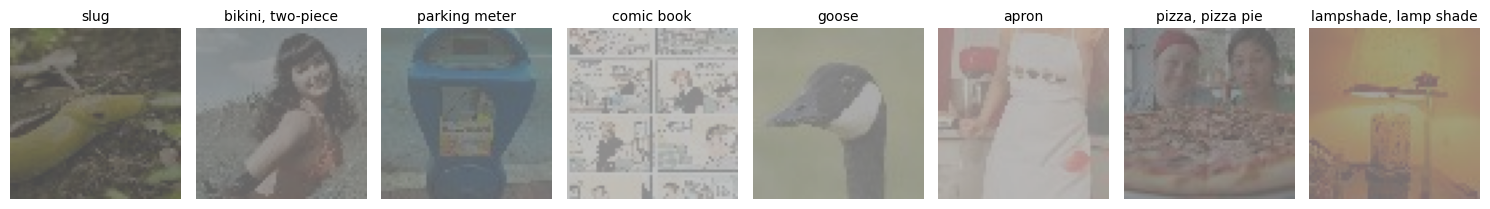

In [6]:
def imshow(img, title=None):
    img = img.numpy().transpose((1, 2, 0))
    plt.imshow(img)
    plt.axis("off")
    if title:
        plt.title(title, fontsize=10)
    plt.show()


def visualize_train_loader(train_loader, classes, num_images=8):
    data_iter = iter(train_loader)
    images, labels = next(data_iter)

    images = images[:num_images]  
    labels = labels[:num_images]

    # Plot the images
    plt.figure(figsize=(15, 10))
    for i in range(num_images):
        ax = plt.subplot(5, num_images, i + 1)
        img = ToPILImage()(images[i]) 
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"{classes[labels[i]]}", fontsize=10)
            
    plt.tight_layout()
    plt.show()

classes = base_dataset.classes
words_df = pd.read_csv("/kaggle/input/tiny-imagenet/tiny-imagenet-200/words.txt", header=None, delimiter='\t', names=["folder", "label"])
labels = [words_df[words_df['folder']==classes[i]]['label'].iloc[0] for i in range(200)]

# Visualize the train loader
visualize_train_loader(train_loader, labels)

In [7]:
class CustomResNet(nn.Module):
    def __init__(self, model, num_classes):
        super(CustomResNet, self).__init__()
        # self.model = model
        model.conv1 = nn.Conv2d(
            in_channels=3, 
            out_channels=64, 
            kernel_size=5,  
            stride=2,       
            padding=1       
        )
        
        self.part = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.avgpool
        )
        
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, 64, 64)
            feature_map = self.part(dummy_input)
            print("Feature map size after layer2:", feature_map.shape)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, num_classes)
        
    def forward(self, x):
        x = self.part(x)         
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = torchvision.models.resnet18(pretrained=False)
x = torch.randn(1, 3, 64, 64)
num_classes = 200
model = CustomResNet(model=model, num_classes=num_classes)
model(x).shape
print(model)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Feature map size after layer2: torch.Size([1, 128, 1, 1])
CustomResNet(
  (part): Sequential(
    (0): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, mome

In [8]:
# Hyperparameters
num_epochs = 128
criterion = nn.CrossEntropyLoss()

# Optimizer: Adam
optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), weight_decay=1e-4)

# Scheduler (StepLR to reduce learning rate every 10 epochs)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# For storing loss and accuracy
train_losses, train_acc, val_losses, val_acc = [], [], [], []

# Best model parameters
best_model_path = 'v2_BothTransforms_DevelopmentalCurriculum.pth'

# Loop through age groups
for age_idx, age_group in enumerate(age_groups):
    print(f"\nStarting training for age group {age_group} months.")
    
    # Reset early stopping parameters for each age group
    patience = 5  # Number of epochs to wait for improvement
    counter = 0    # Counts epochs with no improvement
    best_val_loss = float('inf')  # Best validation loss

    # Loop through epochs for the current age group
    for epoch in range(32):  # 32 epochs per age group
        overall_epoch = epoch + (age_idx * 32) + 1  # Tracking overall epoch number
        print(f"\nEpoch {overall_epoch}/{num_epochs} (Age Group: {age_group} months, Epoch {epoch + 1}/32)")

        # Training phase
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        train_loader_tqdm = tqdm(train_loaders[age_idx], desc="Train Progress", leave=True)

        for inputs, labels in train_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            # Calculate training loss and accuracy
            train_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

            # Update progress bar description with current metrics
            train_loader_tqdm.set_postfix(loss=loss.item())

        train_loss /= len(train_loader.dataset)
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        val_loader_tqdm = tqdm(val_loaders[age_idx], desc="Validation Progress", leave=True)

        with torch.no_grad():
            for inputs, labels in val_loader_tqdm:
                inputs, labels = inputs.to(device), labels.to(device)

                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Calculate validation loss and accuracy
                val_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                correct_val += predicted.eq(labels).sum().item()
                total_val += labels.size(0)

                # Update progress bar description with current metrics
                val_loader_tqdm.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100 * correct_val / total_val

        # Update learning rate scheduler
        scheduler.step()

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_acc.append(train_accuracy)
        val_acc.append(val_accuracy)
        
        print(f"train Loss: {train_loss:.4f}, train_acc: {train_accuracy:.2f}%, val_loss: {val_loss:.4f}, val_acc: {val_accuracy:.2f}%")

        # Early stopping logic
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0  # Reset the counter if validation loss improves
            torch.save(model.state_dict(), best_model_path)  # Save best model
            print(f"Validation loss improved. Saving model to {best_model_path}.")
        else:
            counter += 1
            print(f"No improvement in validation loss. Counter: {counter}/{patience}")
            if counter >= patience:
                print("Early stopping triggered for this age group!")
                break

    print(f"Training completed for age group {age_group} months. Best model saved to {best_model_path}.")

# Load the best model's weights
model.load_state_dict(torch.load(best_model_path))
print(f"Training complete. Best model loaded from {best_model_path}.")


Starting training for age group 1 months.

Epoch 1/128 (Age Group: 1 months, Epoch 1/32)


Validation Progress: 100%|██████████| 313/313 [00:32<00:00,  9.55it/s, loss=4.82]


train Loss: 4.6443, train_acc: 5.97%, val_loss: 4.7201, val_acc: 5.49%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 2/128 (Age Group: 1 months, Epoch 2/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 12.00it/s, loss=5.24]


train Loss: 3.9212, train_acc: 14.14%, val_loss: 5.3299, val_acc: 4.58%
No improvement in validation loss. Counter: 1/5

Epoch 3/128 (Age Group: 1 months, Epoch 3/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.15it/s, loss=5.39]


train Loss: 3.5438, train_acc: 20.21%, val_loss: 5.2371, val_acc: 7.22%
No improvement in validation loss. Counter: 2/5

Epoch 4/128 (Age Group: 1 months, Epoch 4/32)


Validation Progress: 100%|██████████| 313/313 [00:27<00:00, 11.39it/s, loss=6.88]


train Loss: 3.2826, train_acc: 25.06%, val_loss: 6.9349, val_acc: 2.74%
No improvement in validation loss. Counter: 3/5

Epoch 5/128 (Age Group: 1 months, Epoch 5/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.82it/s, loss=4.68]


train Loss: 3.0770, train_acc: 28.64%, val_loss: 4.3137, val_acc: 12.47%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 6/128 (Age Group: 1 months, Epoch 6/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.30it/s, loss=4.2]


train Loss: 2.9149, train_acc: 31.64%, val_loss: 3.9971, val_acc: 15.73%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 7/128 (Age Group: 1 months, Epoch 7/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.36it/s, loss=3.27]


train Loss: 2.7754, train_acc: 34.34%, val_loss: 3.3954, val_acc: 24.81%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 8/128 (Age Group: 1 months, Epoch 8/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.43it/s, loss=4.71]


train Loss: 2.6626, train_acc: 36.47%, val_loss: 5.0766, val_acc: 11.29%
No improvement in validation loss. Counter: 1/5

Epoch 9/128 (Age Group: 1 months, Epoch 9/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.15it/s, loss=2.85]


train Loss: 2.5511, train_acc: 38.68%, val_loss: 3.3926, val_acc: 25.52%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 10/128 (Age Group: 1 months, Epoch 10/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 12.01it/s, loss=3.59]


train Loss: 2.4552, train_acc: 40.49%, val_loss: 3.7387, val_acc: 21.39%
No improvement in validation loss. Counter: 1/5

Epoch 11/128 (Age Group: 1 months, Epoch 11/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.14it/s, loss=3.04]


train Loss: 2.1609, train_acc: 46.94%, val_loss: 3.1283, val_acc: 30.55%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 12/128 (Age Group: 1 months, Epoch 12/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.07it/s, loss=2.34]


train Loss: 2.0552, train_acc: 48.96%, val_loss: 2.9581, val_acc: 33.37%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 13/128 (Age Group: 1 months, Epoch 13/32)


Validation Progress: 100%|██████████| 313/313 [00:24<00:00, 12.52it/s, loss=3.58]


train Loss: 1.9661, train_acc: 50.54%, val_loss: 3.6553, val_acc: 24.67%
No improvement in validation loss. Counter: 1/5

Epoch 14/128 (Age Group: 1 months, Epoch 14/32)


Validation Progress: 100%|██████████| 313/313 [00:24<00:00, 12.63it/s, loss=2.47]


train Loss: 1.8846, train_acc: 52.39%, val_loss: 2.8913, val_acc: 34.63%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 15/128 (Age Group: 1 months, Epoch 15/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.38it/s, loss=2.46]


train Loss: 1.8033, train_acc: 54.16%, val_loss: 3.1566, val_acc: 31.87%
No improvement in validation loss. Counter: 1/5

Epoch 16/128 (Age Group: 1 months, Epoch 16/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.04it/s, loss=2.29]


train Loss: 1.7259, train_acc: 55.65%, val_loss: 3.0338, val_acc: 33.53%
No improvement in validation loss. Counter: 2/5

Epoch 17/128 (Age Group: 1 months, Epoch 17/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.82it/s, loss=3.35]


train Loss: 1.6384, train_acc: 57.76%, val_loss: 3.4099, val_acc: 29.02%
No improvement in validation loss. Counter: 3/5

Epoch 18/128 (Age Group: 1 months, Epoch 18/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.07it/s, loss=2.88]


train Loss: 1.5620, train_acc: 59.26%, val_loss: 3.4375, val_acc: 29.07%
No improvement in validation loss. Counter: 4/5

Epoch 19/128 (Age Group: 1 months, Epoch 19/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.37it/s, loss=2.62]


train Loss: 1.4861, train_acc: 61.03%, val_loss: 3.5014, val_acc: 27.90%
No improvement in validation loss. Counter: 5/5
Early stopping triggered for this age group!
Training completed for age group 1 months. Best model saved to v2_BothTransforms_DevelopmentalCurriculum.pth.

Starting training for age group 6 months.

Epoch 33/128 (Age Group: 6 months, Epoch 1/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.11it/s, loss=2.06]


train Loss: 1.7342, train_acc: 56.77%, val_loss: 2.0477, val_acc: 49.09%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 34/128 (Age Group: 6 months, Epoch 2/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.48it/s, loss=2.1]


train Loss: 1.4268, train_acc: 64.46%, val_loss: 2.0160, val_acc: 50.35%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 35/128 (Age Group: 6 months, Epoch 3/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.88it/s, loss=2.83]


train Loss: 1.3401, train_acc: 66.64%, val_loss: 2.6465, val_acc: 39.31%
No improvement in validation loss. Counter: 1/5

Epoch 36/128 (Age Group: 6 months, Epoch 4/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.60it/s, loss=2.21]


train Loss: 1.2614, train_acc: 68.22%, val_loss: 1.9807, val_acc: 50.86%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 37/128 (Age Group: 6 months, Epoch 5/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 12.03it/s, loss=2.02]


train Loss: 1.1946, train_acc: 69.82%, val_loss: 1.8275, val_acc: 54.88%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 38/128 (Age Group: 6 months, Epoch 6/32)


Validation Progress: 100%|██████████| 313/313 [00:24<00:00, 12.67it/s, loss=2.26]


train Loss: 1.1279, train_acc: 71.43%, val_loss: 1.8654, val_acc: 53.99%
No improvement in validation loss. Counter: 1/5

Epoch 39/128 (Age Group: 6 months, Epoch 7/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.23it/s, loss=2.19]


train Loss: 1.0641, train_acc: 73.10%, val_loss: 1.9017, val_acc: 53.37%
No improvement in validation loss. Counter: 2/5

Epoch 40/128 (Age Group: 6 months, Epoch 8/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.18it/s, loss=3.39]


train Loss: 1.0032, train_acc: 74.54%, val_loss: 3.0881, val_acc: 33.55%
No improvement in validation loss. Counter: 3/5

Epoch 41/128 (Age Group: 6 months, Epoch 9/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.20it/s, loss=2.9]


train Loss: 0.9406, train_acc: 76.18%, val_loss: 2.3817, val_acc: 44.42%
No improvement in validation loss. Counter: 4/5

Epoch 42/128 (Age Group: 6 months, Epoch 10/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.80it/s, loss=3.27]


train Loss: 0.8826, train_acc: 77.69%, val_loss: 3.0340, val_acc: 34.86%
No improvement in validation loss. Counter: 5/5
Early stopping triggered for this age group!
Training completed for age group 6 months. Best model saved to v2_BothTransforms_DevelopmentalCurriculum.pth.

Starting training for age group 12 months.

Epoch 65/128 (Age Group: 12 months, Epoch 1/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.94it/s, loss=1.67]


train Loss: 1.1020, train_acc: 72.24%, val_loss: 1.3201, val_acc: 65.72%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 66/128 (Age Group: 12 months, Epoch 2/32)


Validation Progress: 100%|██████████| 313/313 [00:24<00:00, 12.61it/s, loss=1.66]


train Loss: 0.8773, train_acc: 78.84%, val_loss: 1.0455, val_acc: 74.00%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 67/128 (Age Group: 12 months, Epoch 3/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.84it/s, loss=1.58]


train Loss: 0.8183, train_acc: 80.47%, val_loss: 1.0471, val_acc: 73.67%
No improvement in validation loss. Counter: 1/5

Epoch 68/128 (Age Group: 12 months, Epoch 4/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.88it/s, loss=2.03]


train Loss: 0.7718, train_acc: 81.68%, val_loss: 1.5269, val_acc: 60.41%
No improvement in validation loss. Counter: 2/5

Epoch 69/128 (Age Group: 12 months, Epoch 5/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.91it/s, loss=1.81]


train Loss: 0.7327, train_acc: 82.66%, val_loss: 1.1435, val_acc: 70.37%
No improvement in validation loss. Counter: 3/5

Epoch 70/128 (Age Group: 12 months, Epoch 6/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.26it/s, loss=1.98]


train Loss: 0.6916, train_acc: 83.89%, val_loss: 1.3763, val_acc: 63.83%
No improvement in validation loss. Counter: 4/5

Epoch 71/128 (Age Group: 12 months, Epoch 7/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.24it/s, loss=1.7]


train Loss: 0.6580, train_acc: 84.72%, val_loss: 1.2433, val_acc: 67.44%
No improvement in validation loss. Counter: 5/5
Early stopping triggered for this age group!
Training completed for age group 12 months. Best model saved to v2_BothTransforms_DevelopmentalCurriculum.pth.

Starting training for age group 24 months.

Epoch 97/128 (Age Group: 24 months, Epoch 1/32)


Validation Progress: 100%|██████████| 313/313 [00:24<00:00, 12.77it/s, loss=0.97]


train Loss: 0.7601, train_acc: 81.50%, val_loss: 0.7367, val_acc: 82.19%
Validation loss improved. Saving model to v2_BothTransforms_DevelopmentalCurriculum.pth.

Epoch 98/128 (Age Group: 24 months, Epoch 2/32)


Validation Progress: 100%|██████████| 313/313 [00:24<00:00, 12.75it/s, loss=0.938]


train Loss: 0.6903, train_acc: 83.52%, val_loss: 0.7837, val_acc: 80.36%
No improvement in validation loss. Counter: 1/5

Epoch 99/128 (Age Group: 24 months, Epoch 3/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.20it/s, loss=1.19]


train Loss: 0.6457, train_acc: 84.89%, val_loss: 0.8568, val_acc: 77.87%
No improvement in validation loss. Counter: 2/5

Epoch 100/128 (Age Group: 24 months, Epoch 4/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.89it/s, loss=1.25]


train Loss: 0.6064, train_acc: 85.85%, val_loss: 0.9590, val_acc: 74.19%
No improvement in validation loss. Counter: 3/5

Epoch 101/128 (Age Group: 24 months, Epoch 5/32)


Validation Progress: 100%|██████████| 313/313 [00:26<00:00, 11.90it/s, loss=1.06]


train Loss: 0.5125, train_acc: 89.13%, val_loss: 0.8179, val_acc: 78.92%
No improvement in validation loss. Counter: 4/5

Epoch 102/128 (Age Group: 24 months, Epoch 6/32)


Validation Progress: 100%|██████████| 313/313 [00:25<00:00, 12.40it/s, loss=1.08]

train Loss: 0.4921, train_acc: 89.92%, val_loss: 0.9123, val_acc: 75.76%
No improvement in validation loss. Counter: 5/5
Early stopping triggered for this age group!
Training completed for age group 24 months. Best model saved to v2_BothTransforms_DevelopmentalCurriculum.pth.
Training complete. Best model loaded from v2_BothTransforms_DevelopmentalCurriculum.pth.



<ipython-input-8-c018753b0498>:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [9]:
# Save the model weights
torch.save(model.state_dict(), 'weights_v2_BothTransforms_DevelopmentalCurriculum.pth')

In [10]:
final_checkpoint_path = "v2_BothTransforms_DevelopmentalCurriculum_checkpoint.pth"

checkpoint = {
    'epoch': epoch + 1,  # Save the current epoch
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_acc': train_acc,
    'val_acc': val_acc,
    'best_val_loss': best_val_loss,
}
torch.save(checkpoint, final_checkpoint_path)

In [11]:
'''
# Load the saved checkpoint
checkpoint = torch.load(final_checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
scheduler.load_state_dict(checkpoint['scheduler_state_dict'])

# Resume from the saved epoch and other metrics
start_epoch = checkpoint['epoch']
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_acc = checkpoint['train_acc']
val_acc = checkpoint['val_acc']
best_val_loss = checkpoint['best_val_loss']

print(f"Resuming training from epoch {start_epoch}")
'''

'\n# Load the saved checkpoint\ncheckpoint = torch.load(final_checkpoint_path)\nmodel.load_state_dict(checkpoint[\'model_state_dict\'])\noptimizer.load_state_dict(checkpoint[\'optimizer_state_dict\'])\nscheduler.load_state_dict(checkpoint[\'scheduler_state_dict\'])\n\n# Resume from the saved epoch and other metrics\nstart_epoch = checkpoint[\'epoch\']\ntrain_losses = checkpoint[\'train_losses\']\nval_losses = checkpoint[\'val_losses\']\ntrain_acc = checkpoint[\'train_acc\']\nval_acc = checkpoint[\'val_acc\']\nbest_val_loss = checkpoint[\'best_val_loss\']\n\nprint(f"Resuming training from epoch {start_epoch}")\n'

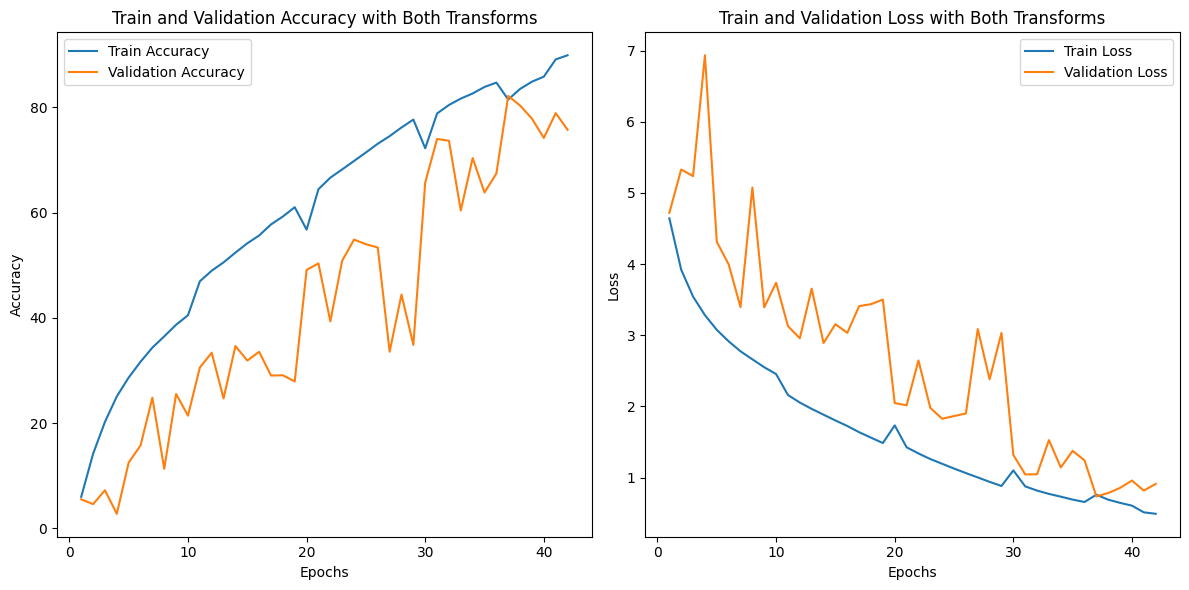

Plot saved to BothTransforms_DevelopmentalCurriculum_epochs_plot.png


<Figure size 640x480 with 0 Axes>

In [12]:
# Determine completed epochs based on the collected metrics
completed_epochs = len(train_losses)  # Matches the length of collected metrics
epochs = np.arange(completed_epochs) + 1  # Generate array of epochs from 1 to completed_epochs

# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc[:completed_epochs], label="Train Accuracy")
plt.plot(epochs, val_acc[:completed_epochs], label="Validation Accuracy")
plt.title("Train and Validation Accuracy with Both Transforms")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses[:completed_epochs], label="Train Loss")
plt.plot(epochs, val_losses[:completed_epochs], label="Validation Loss")
plt.title("Train and Validation Loss with Both Transforms")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

# Save the plot after displaying it
plot_path = "BothTransforms_DevelopmentalCurriculum_epochs_plot.png"
plt.savefig(plot_path, dpi=300, bbox_inches="tight")
print(f"Plot saved to {plot_path}")

Plot saved to BothTransforms_DevelopmentalCurriculum_with_stages.png


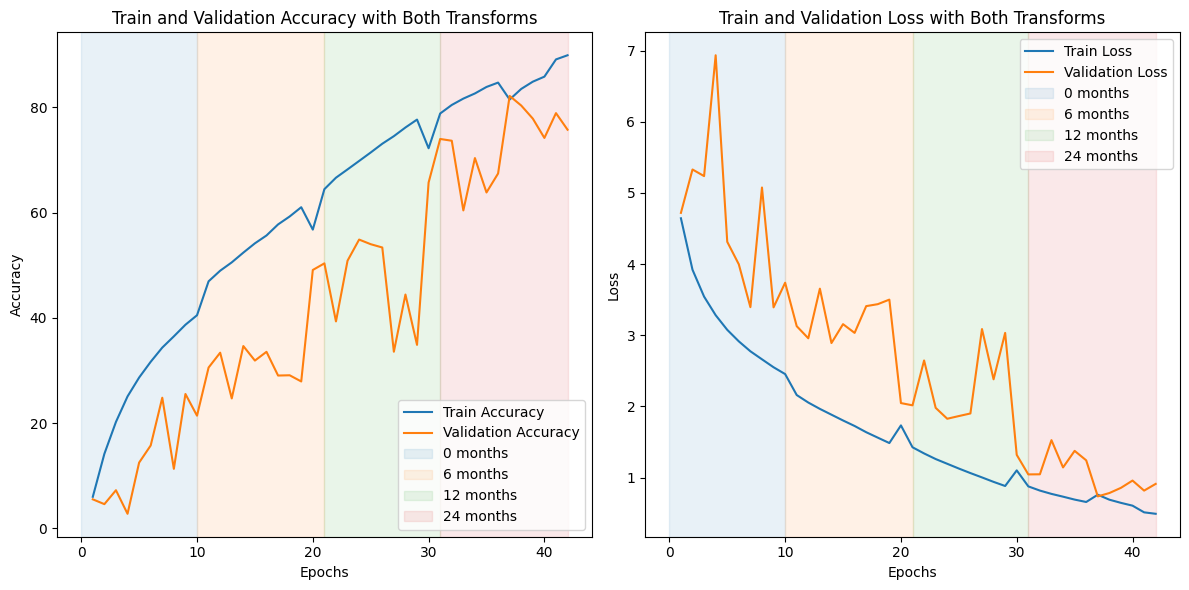

In [13]:
# Adjust the number of completed epochs based on early stopping
completed_epochs = len(train_losses)  # Matches the length of collected metrics
epochs = np.arange(completed_epochs) + 1

# Age groups and dynamically scaled group epochs
age_groups = [0, 6, 12, 24]
group_epochs = [0] + [int(completed_epochs * (i / len(age_groups))) for i in range(1, len(age_groups) + 1)]

# Plotting accuracy and loss
plt.figure(figsize=(12, 6))

# Plotting accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc[:completed_epochs], label="Train Accuracy")
plt.plot(epochs, val_acc[:completed_epochs], label="Validation Accuracy")
plt.title("Train and Validation Accuracy with Both Transforms")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

# Adding shaded regions for age groups
for i in range(len(group_epochs) - 1):
    plt.axvspan(group_epochs[i], group_epochs[i + 1], color=f"C{i}", alpha=0.1, label=f"{age_groups[i]} months")
plt.legend(loc="lower right")

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses[:completed_epochs], label="Train Loss")
plt.plot(epochs, val_losses[:completed_epochs], label="Validation Loss")
plt.title("Train and Validation Loss with Both Transforms")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Adding shaded regions for age groups
for i in range(len(group_epochs) - 1):
    plt.axvspan(group_epochs[i], group_epochs[i + 1], color=f"C{i}", alpha=0.1, label=f"{age_groups[i]} months")
plt.legend(loc="upper right")

plt.tight_layout()

# Save the plot as an image file
plot_path = "BothTransforms_DevelopmentalCurriculum_with_stages.png"  # File name and format
plt.savefig(plot_path, dpi=300, bbox_inches="tight")  # Save with high resolution
print(f"Plot saved to {plot_path}")
plt.show()

Figure saved to with_Both_Transforms.png


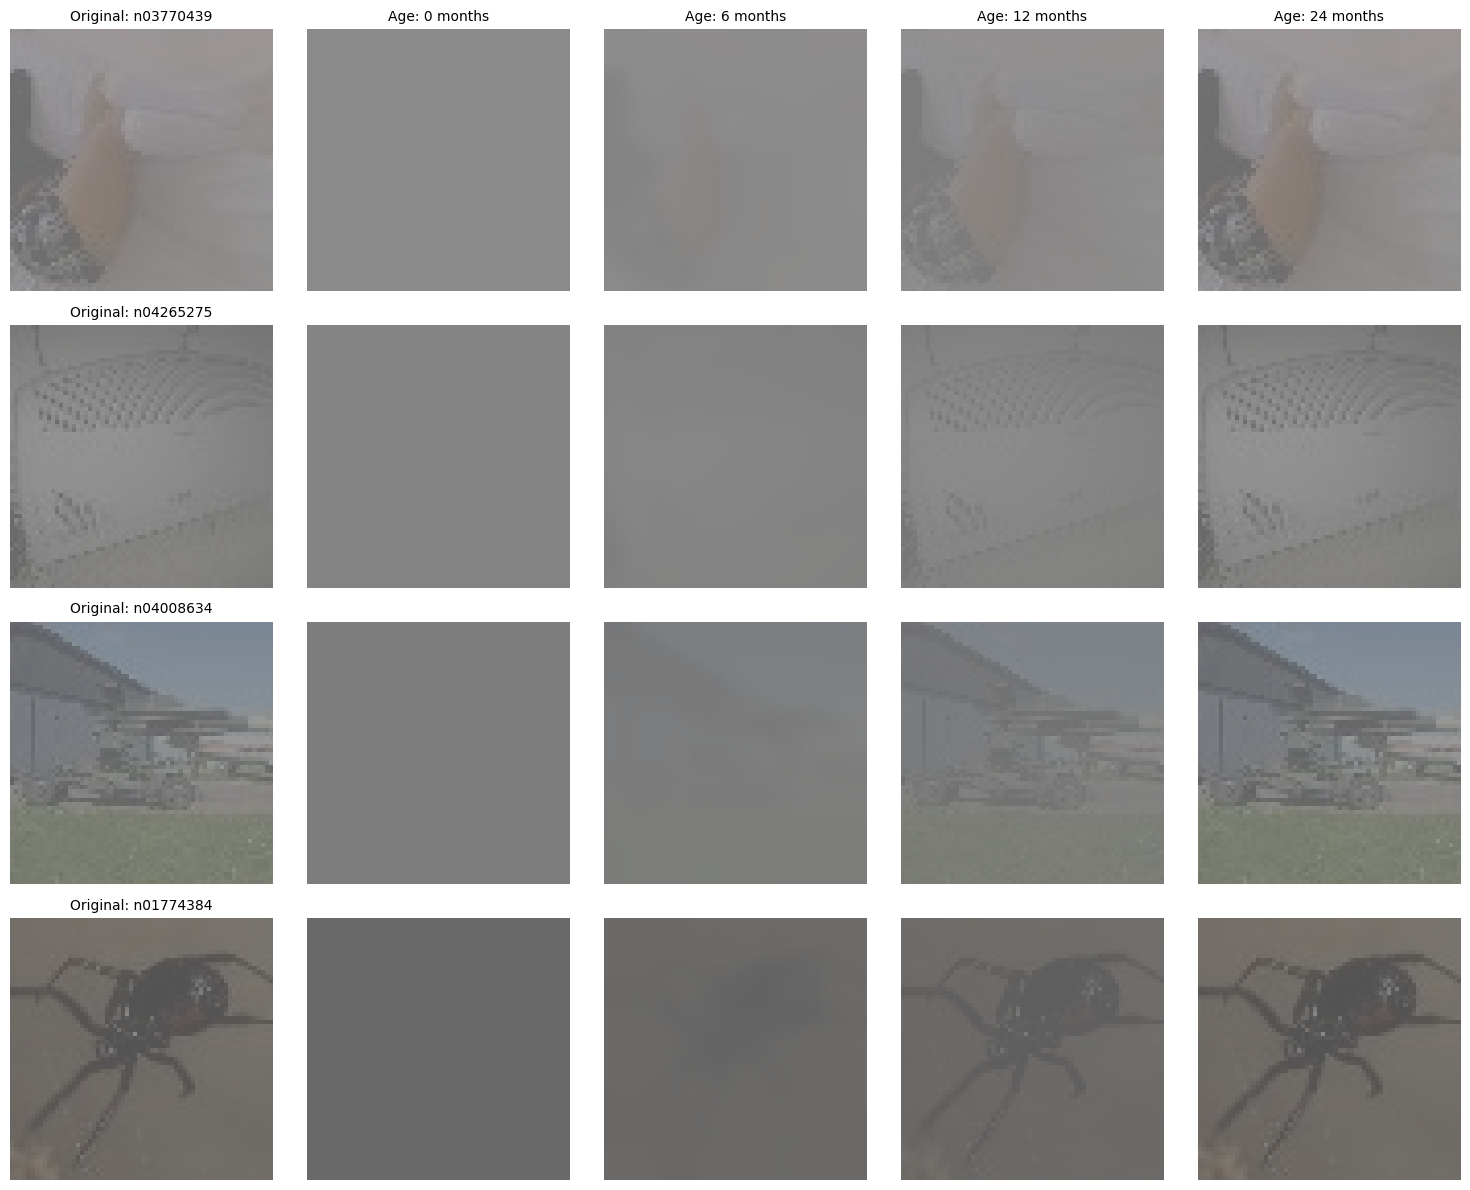

In [14]:
import random 
def visualize_transformations(base_dataset, age_groups, num_images=4, save_path="with_Both_Transforms.png"):
    # Set a fixed random seed to ensure reproducibility for selecting the same 4 images
    random.seed(40)
    indices = random.sample(range(len(base_dataset)), num_images)

    # Create a figure to plot the images
    plt.figure(figsize=(15, len(indices) * 3))

    for i, img_idx in enumerate(indices):
        # Get the original image and its label
        original_img, label = base_dataset[img_idx]
        original_img_pil = ToPILImage()(original_img)

        # Plot the original image in the first column
        plt.subplot(len(indices), len(age_groups) + 1, i * (len(age_groups) + 1) + 1)
        plt.imshow(original_img_pil)
        plt.axis("off")
        plt.title(f"Original: {classes[label]}", fontsize=10)
        plt.ylabel(f"Image {i + 1}", fontsize=12)

        # Apply each transformation and plot the result
        for j, age_in_months in enumerate(age_groups):
            transform = transforms.Compose([
                AcuityBlur(age_in_months=age_in_months),
                ContrastAdjust(age_in_months=age_in_months),
                transforms.ToTensor()
            ])
            base_dataset.transform = transform

            transformed_img, _ = base_dataset[img_idx]  # Apply the transformation
            transformed_img_pil = ToPILImage()(transformed_img)

            # Plot the transformed image in the corresponding column
            plt.subplot(len(indices), len(age_groups) + 1, i * (len(age_groups) + 1) + j + 2)
            plt.imshow(transformed_img_pil)
            plt.axis("off")
            if i == 0:
                plt.title(f"Age: {age_in_months} months", fontsize=10)

    plt.tight_layout()

    # Save the figure
    plt.savefig(save_path, dpi=300)
    print(f"Figure saved to {save_path}")

    plt.show()

# Visualize transformations for 5 randomly selected images and save the figure
visualize_transformations(base_dataset, age_groups, num_images=4, save_path="with_Both_Transforms.png")